In [1]:
import os
import gc
import logging
import random
import string
import re
from abc import ABC, abstractmethod

import networkx as nx
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from transformers import GPT2LMHeadModel, GPT2TokenizerFast
import itertools

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logging.getLogger("transformers").setLevel(logging.ERROR)

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed()


/cs/student/projects1/aibh/2024/cbaumgar/.venv/lib64/python3.9/site-packages/networkx/utils/backends.py:135: RuntimeWarning: networkx backend defined more than once: nx-loopback
  backends.update(_get_backends("networkx.backends"))
/cs/student/projects1/aibh/2024/cbaumgar/.venv/lib64/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class NavigationGPT:
    def __init__(self, model_path: str):
        self.tokenizer = GPT2TokenizerFast.from_pretrained(model_path)
        if self.tokenizer.pad_token is None: self.tokenizer.pad_token = self.tokenizer.eos_token
        self.model = GPT2LMHeadModel.from_pretrained(model_path, torch_dtype=torch.float32)
        self.model.config.pad_token_id = self.tokenizer.pad_token_id
        self.model.to(DEVICE)
        self.model.eval()

    def generate(self, prompt: str, max_new_tokens: int = 60):
        encodings = self.tokenizer(prompt, return_tensors='pt').to(DEVICE)
        with torch.no_grad():
            output_ids = self.model.generate(**encodings, max_new_tokens=max_new_tokens, num_beams=1)
        return self.tokenizer.decode(output_ids[0, encodings.input_ids.shape[1]:], skip_special_tokens=True).strip()

def generate_grid_graph(size=4):
    G = nx.DiGraph()
    num_nodes = size * size
    nodes = list(set([''.join(random.choices(string.ascii_lowercase, k=2)) for _ in range(num_nodes*2)]))[:num_nodes]
    node_map = [['' for _ in range(size)] for _ in range(size)]
    for r in range(size):
        for c in range(size):
            idx = r * size + c
            node_map[r][c] = nodes[idx]
            if c < size - 1: G.add_edge(nodes[idx], nodes[idx+1], direction='EAST')
            if c > 0: G.add_edge(nodes[idx], nodes[idx-1], direction='WEST')
            if r < size - 1: G.add_edge(nodes[idx], nodes[idx+size], direction='SOUTH')
            if r > 0: G.add_edge(nodes[idx], nodes[idx-size], direction='NORTH')
    return G, nodes, node_map

def find_hamiltonian_path(G, max_retries=10):
    for _ in range(max_retries):
        start_node = random.choice(list(G.nodes()))
        path, visited = [start_node], {start_node}
        def search(current):
            if len(path) == len(G.nodes()): return True
            neighbors = list(G.successors(current)); random.shuffle(neighbors)
            for neighbor in neighbors:
                if neighbor not in visited:
                    visited.add(neighbor); path.append(neighbor)
                    if search(neighbor): return True
                    path.pop(); visited.remove(neighbor)
            return False
        if search(start_node): return path
    logging.warning("Failed to find a Hamiltonian path after multiple retries.")
    return None

def find_snake_hamiltonian_path(G, node_map):
    path_nodes = []
    size = len(node_map)
    for r in range(size):
        row_iterator = range(size) if r % 2 == 0 else reversed(range(size))
        for c in row_iterator: path_nodes.append(node_map[r][c])
    return path_nodes

def generate_random_walk(G, length):
    start_node = random.choice(list(G.nodes()))
    path = [start_node]
    for _ in range(length - 1):
        neighbors = list(G.successors(path[-1]))
        if not neighbors: break
        path.append(random.choice(neighbors))
    return path

def walk_to_string(walk, G):
    if not walk or len(walk) < 2: return walk[0] if walk else ""
    return " ".join([f"{walk[i]} {G.edges[walk[i], walk[i+1]]['direction']}" for i in range(len(walk)-1)] + [walk[-1]])

def get_node_coords(node_name, node_map):
    for r, row in enumerate(node_map):
        if node_name in row: return (r, row.index(node_name))
    return None

def get_manhattan_distance(n1, n2, node_map):
    c1, c2 = get_node_coords(n1, node_map), get_node_coords(n2, node_map)
    return abs(c1[0] - c2[0]) + abs(c1[1] - c2[1]) if c1 and c2 else float('inf')

def create_test_cases(params):
    test_cases = []
    task_type = params.get("task_type", "random_pairs")
    if task_type == "all_pairs":
        G, nodes, node_map = generate_grid_graph(params['grid_size'])
        if params.get("context_structure") == "snake": context = find_snake_hamiltonian_path(G, node_map)
        else: context = find_hamiltonian_path(G)
        for start_node, end_node in itertools.permutations(nodes, 2):
            test_cases.append({'graph': G, 'node_map': node_map, 'start': start_node, 'end': end_node, 'context': context})
        return test_cases

    pbar = tqdm(total=params['num_tests'], desc=f"Generating tasks for {task_type}")
    attempts, max_total_attempts = 0, params['num_tests'] * 200
    while len(test_cases) < params['num_tests'] and attempts < max_total_attempts:
        attempts += 1
        G, nodes, node_map = generate_grid_graph(params['grid_size'])
        if task_type == 'opposite_edge':
            edge, size = [0, params['grid_size'] - 1], params['grid_size']
            if random.random() > 0.5: r = random.randint(0, size - 1); start_node, end_node = node_map[r][edge[0]], node_map[r][edge[1]]
            else: c = random.randint(0, size - 1); start_node, end_node = node_map[edge[0]][c], node_map[edge[1]][c]
        elif task_type == 'high_manhattan_distance':
            s, e = random.sample(nodes, 2)
            if get_manhattan_distance(s, e, node_map) <= 6: continue
            start_node, end_node = s, e
        else: start_node, end_node = random.sample(nodes, 2)

        if params.get("context_solvability") == "guaranteed" and params['context_type'] == 'random_walk':
            try:
                all_solution_paths = list(nx.all_shortest_paths(G, start_node, end_node))
                if not all_solution_paths: continue
                list_of_required_nodes = [set(p) for p in all_solution_paths]
            except nx.NetworkXNoPath: continue
            context_found = False
            for _ in range(200):
                context = generate_random_walk(G, params['context_walk_length'])
                nodes_in_walk = set(context)
                if any(req.issubset(nodes_in_walk) for req in list_of_required_nodes): context_found = True; break
            if not context_found: continue
        else:
            if params['context_type'] == 'hamiltonian': context = find_hamiltonian_path(G)
            elif params['context_type'] == 'random_walk': context = generate_random_walk(G, params['context_walk_length'])
            else: context = []
        if context: test_cases.append({'graph': G, 'node_map': node_map, 'start': start_node, 'end': end_node, 'context': context}); pbar.update(1)
    pbar.close()
    if len(test_cases) < params['num_tests']: logging.warning(f"Warning: Only generated {len(test_cases)}/{params['num_tests']} cases.")
    return test_cases

def parse_path(text): return re.findall(r'\b[a-z]{2}\b', text)
def is_valid_path(nodes, G): return all(G.has_edge(nodes[i], nodes[i+1]) for i in range(len(nodes)-1))

def score_and_analyze(parsed_nodes, task):
    try:
        all_shortest_paths = list(nx.all_shortest_paths(task['graph'], task['start'], task['end']))
        if not all_shortest_paths: raise nx.NetworkXNoPath
        expected_len = len(all_shortest_paths[0])
    except (nx.NetworkXNoPath, nx.NodeNotFound): all_shortest_paths, expected_len = [], -1
    is_path_valid = is_valid_path(parsed_nodes, task['graph'])
    is_correct = is_path_valid and all_shortest_paths and len(parsed_nodes) == expected_len and parsed_nodes in all_shortest_paths
    try: path_dist_in_context = abs(task['context'].index(task['end']) - task['context'].index(task['start']))
    except (ValueError, IndexError): path_dist_in_context = float('inf')
    return {
        'accuracy': 1.0 if is_correct else 0.0, 'is_valid': is_path_valid,
        'expected_len': expected_len, 'manhattan_distance': get_manhattan_distance(task['start'], task['end'], task['node_map']),
        'path_distance_in_context': path_dist_in_context
    }

def run_advanced_analysis(model_config: dict, test_cases: list, model_name: str = "model"):
    if not test_cases:
        logging.warning(f"Skipping evaluation for {model_name} as no test cases were provided.")
        return pd.DataFrame()

    try:
        model = NavigationGPT(model_config['path'])
    except Exception as e:
        logging.error(f"SKIPPING {model_name}: Failed to load model. Error: {e}")
        return pd.DataFrame()

    results = []
    desc = f"Evaluating {model_name}"
    for task in tqdm(test_cases, desc=desc):
        prompt = model_config['strategy'].create_prompt(task)
        generated_text = model.generate(prompt)
        parsed_nodes = parse_path(generated_text)
        analysis_metrics = score_and_analyze(parsed_nodes, task)
        results.append(analysis_metrics)

    del model
    gc.collect()
    torch.cuda.empty_cache()

    return pd.DataFrame(results)

class ExperimentLogger:
    def __init__(self):
        self._summary_results = []
        self._detailed_results_list = []

    def add(self, model_name: str, analysis_name: str, results_df: pd.DataFrame):
        if results_df.empty:
            logging.warning(f"Skipped logging for {model_name}/{analysis_name} due to empty results.")
            return

        accuracy = results_df['accuracy'].mean()
        self._summary_results.append({
            "Model": model_name,
            "Analysis": analysis_name,
            "Accuracy": accuracy
        })
        logging.info(f"Logged: Model={model_name}, Analysis={analysis_name}, Accuracy={accuracy:.2%}")

        detailed_df_copy = results_df.copy()
        detailed_df_copy['Model'] = model_name
        detailed_df_copy['Analysis'] = analysis_name
        self._detailed_results_list.append(detailed_df_copy)

    def get_summary_df(self) -> pd.DataFrame:
        if not self._summary_results:
            return pd.DataFrame()
        
        summary_df = pd.DataFrame(self._summary_results).drop_duplicates(
            subset=['Model', 'Analysis'], keep='last'
        )
        pivot_table = summary_df.pivot_table(index='Model', columns='Analysis', values='Accuracy')
        
        desired_order = [
            "Baseline_4x4_Hamiltonian",
            "RW_Context_Len_10", "RW_Context_Len_16", "RW_Context_Len_50", "RW_Context_Len_55",
            "Generalization_5x5_Full", "Generalization_5x5_OppositeEdge", "Generalization_5x5_HighMD"
        ]
        
        ordered_cols = [col for col in desired_order if col in pivot_table.columns]
        return pivot_table.reindex(columns=ordered_cols)

    def get_detailed_df(self, analysis_name: str = None) -> pd.DataFrame:
        if not self._detailed_results_list:
            return pd.DataFrame()
        
        full_df = pd.concat(self._detailed_results_list, ignore_index=True)
        
        if analysis_name:
            return full_df[full_df['Analysis'] == analysis_name]
        return full_df

    def save_summary(self, base_filename="experiment_summary"):
        summary_df = self.get_summary_df()
        if summary_df.empty:
            return
        json_path = f"{base_filename}.json"
        summary_df.to_json(json_path, orient='index', indent=4)
        md_path = f"{base_filename}.md"
        with open(md_path, 'w') as f:
            f.write(f"# Experiment Performance Summary\n\n")
            f.write(summary_df.to_markdown())

    def save_detailed_results(self, base_filename="experiment_detailed_results"):
        detailed_df = self.get_detailed_df()
        if detailed_df.empty:
            return
        csv_path = f"{base_filename}.csv"
        detailed_df.to_csv(csv_path, index=False)

def plot_stratified_results(combined_df: pd.DataFrame, analysis_name: str):
    if combined_df.empty:
        logging.warning(f"Skipping plot for '{analysis_name}' due to empty data.")
        return
        
    fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
    fig.suptitle(f'Performance Analysis: {analysis_name}', fontsize=16)
    
    sns.lineplot(data=combined_df, x='manhattan_distance', y='accuracy', hue='Model', 
                 errorbar='ci', ax=axes[0], marker='o')
    axes[0].set_title('Accuracy vs. Path Difficulty')
    axes[0].set_xlabel('Manhattan Distance between Start/End')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_ylim(-0.05, 1.05)
    axes[0].grid(True, linestyle='--', alpha=0.6)
    
    df_filtered = combined_df[combined_df['path_distance_in_context'] != float('inf')]
    if not df_filtered.empty:
        sns.lineplot(data=df_filtered, x='path_distance_in_context', y='accuracy', hue='Model', 
                     errorbar='ci', ax=axes[1], marker='o')
        axes[1].set_title('Accuracy vs. Contextual Proximity')
        axes[1].set_xlabel('Start-End Distance in Context Walk')
    else:
        axes[1].set_title('No Valid In-Context Paths Found')
        
    axes[1].set_ylabel('')
    axes[1].grid(True, linestyle='--', alpha=0.6)
    axes[1].legend().set_visible(False)
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


In [3]:
class PromptStrategy(ABC):
    @abstractmethod
    def create_prompt(self, task: dict) -> str:
        pass

class StandardInstructionalStrategy(PromptStrategy):
    def create_prompt(self, task: dict) -> str:
        map_context_str = walk_to_string(task['context'], task['graph'])
        instruction = f"[SHORTEST] [START_NODE] {task['start']} [GOAL] {task['end']}"
        return f"[SOS] {map_context_str} [SEP] {instruction} [PLAN]"

MODELS_TO_ANALYZE = {
    "SP-RW": {
        "path": "/cs/student/projects1/aibh/2024/cbaumgar/MSC_THESIS/sv3_model_ft/checkpoint-163000",
        "strategy": StandardInstructionalStrategy()
    },
    "SP-Hamiltonian": {
        "path": "/cs/student/projects1/aibh/2024/cbaumgar/MSC_THESIS/sv2_model_fixed/save-checkpoint-46000",
        "strategy": StandardInstructionalStrategy()
    },
}

ADVANCED_ANALYSIS_PARAMS = {
    "Baseline_4x4_Hamiltonian": {
        "num_tests": 200, "grid_size": 4, "context_type": "hamiltonian"
    },
    "RandomWalk_Parametric": {
        "num_tests": 200, "grid_size": 4, "context_type": "random_walk",
        "context_walk_lengths": [10, 16, 50, 55],
        "context_solvability": "guaranteed"
    },
    "Generalization_3x3_RW16": {
        "num_tests": 200, "grid_size": 3, "context_type": "random_walk",
        "context_walk_length": 16, "context_solvability": "guaranteed"
    },
    "Generalization_5x5_RW16": {
        "num_tests": 200, "grid_size": 5, "context_type": "random_walk",
        "context_walk_length": 16, "context_solvability": "guaranteed"
    },
}

logger = ExperimentLogger()


Evaluating SP-RW: 100%|██████████| 200/200 [00:08<00:00, 22.43it/s]
2025-09-22 17:46:27,092 - INFO - Logged: Model=SP-RW, Analysis=Baseline_4x4_Hamiltonian, Accuracy=94.00%
Evaluating SP-Hamiltonian: 100%|██████████| 200/200 [00:08<00:00, 23.89it/s]
2025-09-22 17:46:35,655 - INFO - Logged: Model=SP-Hamiltonian, Analysis=Baseline_4x4_Hamiltonian, Accuracy=100.00%


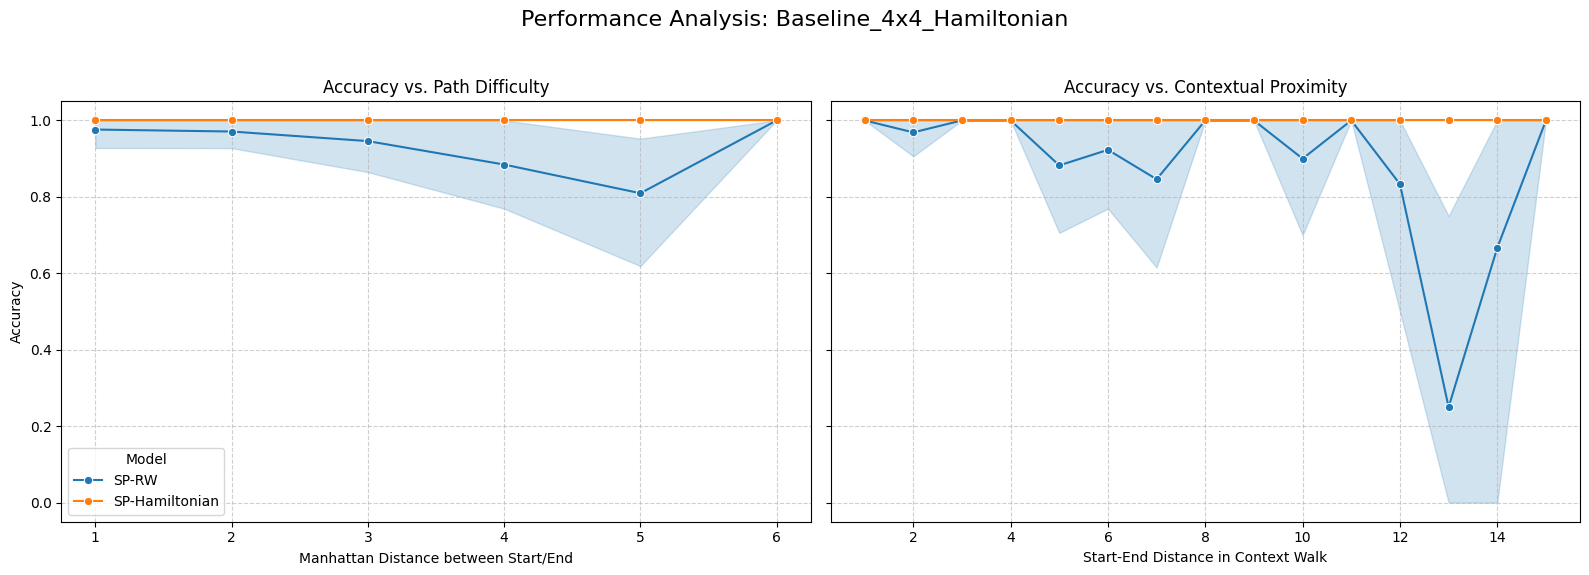

In [4]:
analysis_name = "Baseline_4x4_Hamiltonian"
params = ADVANCED_ANALYSIS_PARAMS[analysis_name]

shared_test_cases = create_test_cases(params)

if not shared_test_cases:
    logging.warning(f"Skipping analysis '{analysis_name}' as no test cases could be generated.")
else:
    for model_name, config in MODELS_TO_ANALYZE.items():
        results_df = run_advanced_analysis(config, shared_test_cases, model_name)
        logger.add(model_name, analysis_name, results_df)

    combined_df_for_plotting = logger.get_detailed_df(analysis_name=analysis_name)
    
    if not combined_df_for_plotting.empty:
        plot_stratified_results(combined_df_for_plotting, analysis_name)


Evaluating SP-RW: 100%|██████████| 200/200 [00:08<00:00, 24.65it/s]
2025-09-22 17:46:44,365 - INFO - Logged: Model=SP-RW, Analysis=RW_Context_Len_10, Accuracy=98.50%
Evaluating SP-Hamiltonian: 100%|██████████| 200/200 [00:14<00:00, 13.92it/s]
2025-09-22 17:46:58,909 - INFO - Logged: Model=SP-Hamiltonian, Analysis=RW_Context_Len_10, Accuracy=0.00%


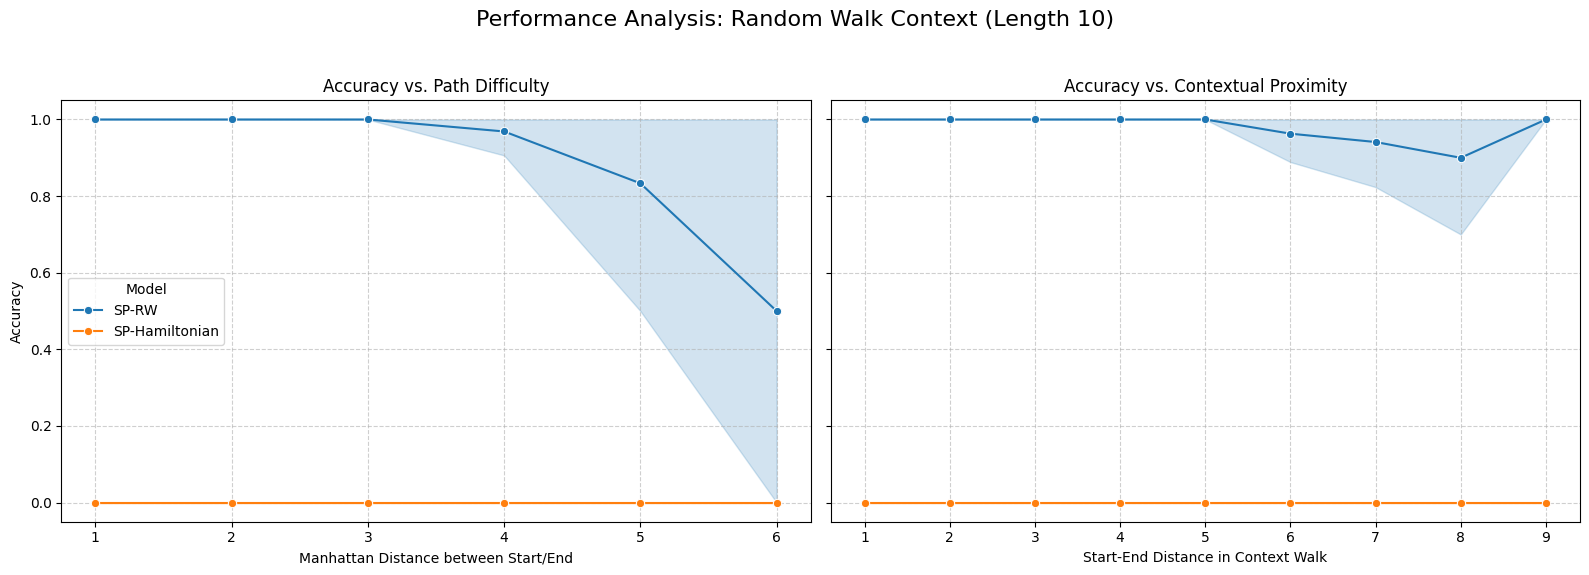

Evaluating SP-RW: 100%|██████████| 200/200 [00:06<00:00, 32.22it/s]
2025-09-22 17:47:05,630 - INFO - Logged: Model=SP-RW, Analysis=RW_Context_Len_16, Accuracy=99.50%
Evaluating SP-Hamiltonian: 100%|██████████| 200/200 [00:05<00:00, 35.27it/s]
2025-09-22 17:47:11,450 - INFO - Logged: Model=SP-Hamiltonian, Analysis=RW_Context_Len_16, Accuracy=39.00%


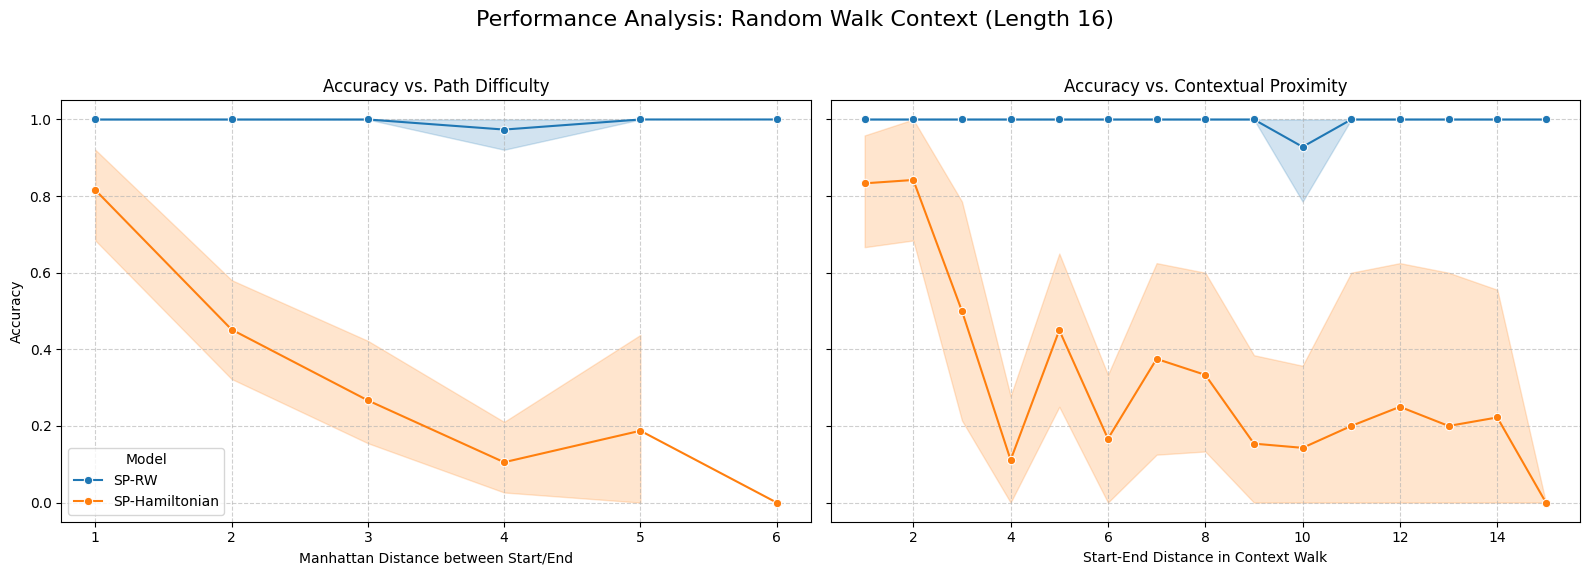

Evaluating SP-RW: 100%|██████████| 200/200 [00:05<00:00, 34.93it/s]
2025-09-22 17:47:17,703 - INFO - Logged: Model=SP-RW, Analysis=RW_Context_Len_50, Accuracy=97.00%
Evaluating SP-Hamiltonian: 100%|██████████| 200/200 [00:28<00:00,  7.12it/s]
2025-09-22 17:47:45,931 - INFO - Logged: Model=SP-Hamiltonian, Analysis=RW_Context_Len_50, Accuracy=0.00%


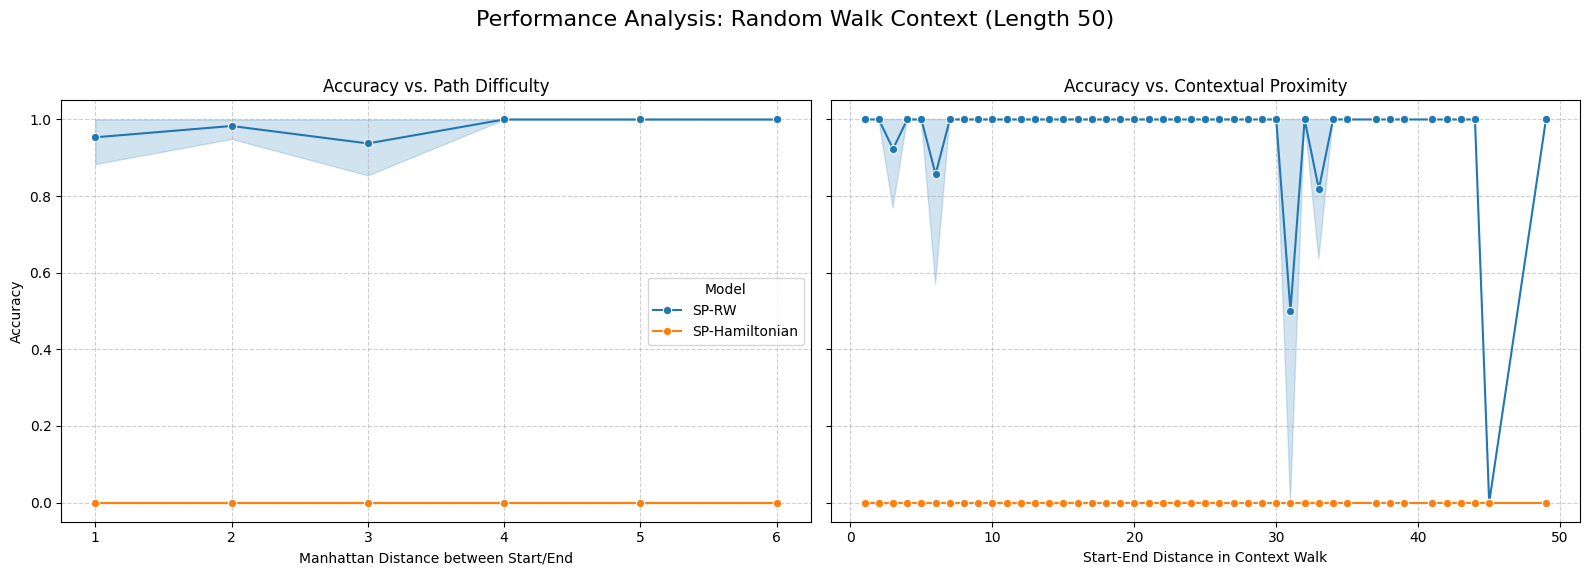

Evaluating SP-RW: 100%|██████████| 200/200 [00:07<00:00, 27.02it/s]
2025-09-22 17:47:54,046 - INFO - Logged: Model=SP-RW, Analysis=RW_Context_Len_55, Accuracy=17.50%
Evaluating SP-Hamiltonian: 100%|██████████| 200/200 [00:28<00:00,  6.94it/s]
2025-09-22 17:48:23,008 - INFO - Logged: Model=SP-Hamiltonian, Analysis=RW_Context_Len_55, Accuracy=0.00%


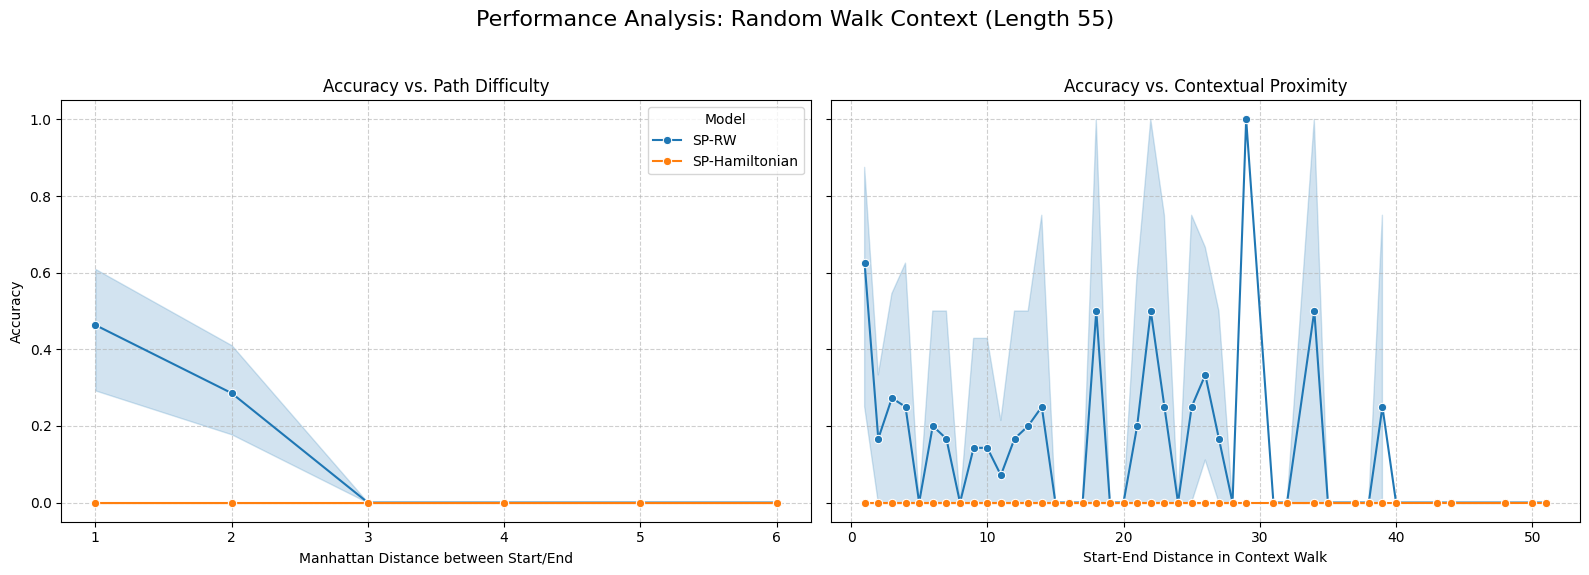

In [5]:
analysis_name_base = "RandomWalk_Parametric"
base_params = ADVANCED_ANALYSIS_PARAMS[analysis_name_base]

for walk_len in base_params['context_walk_lengths']:
    current_analysis_name = f"RW_Context_Len_{walk_len}"
    params = base_params.copy()
    params['context_walk_length'] = walk_len
    
    shared_test_cases = create_test_cases(params)

    if not shared_test_cases:
        logging.warning(f"Skipping analysis for walk length {walk_len} as no test cases generated.")
        continue

    for model_name, config in MODELS_TO_ANALYZE.items():
        results_df = run_advanced_analysis(config, shared_test_cases, model_name)
        logger.add(model_name, current_analysis_name, results_df)

    combined_df_for_plotting = logger.get_detailed_df(analysis_name=current_analysis_name)
    
    if not combined_df_for_plotting.empty:
        plot_stratified_results(combined_df_for_plotting, f"Random Walk Context (Length {walk_len})")


Evaluating SP-RW: 100%|██████████| 200/200 [00:04<00:00, 43.68it/s]
2025-09-22 17:48:28,326 - INFO - Logged: Model=SP-RW, Analysis=Generalization_3x3_RW16, Accuracy=100.00%
Evaluating SP-Hamiltonian: 100%|██████████| 200/200 [00:05<00:00, 38.16it/s]
2025-09-22 17:48:33,725 - INFO - Logged: Model=SP-Hamiltonian, Analysis=Generalization_3x3_RW16, Accuracy=38.00%


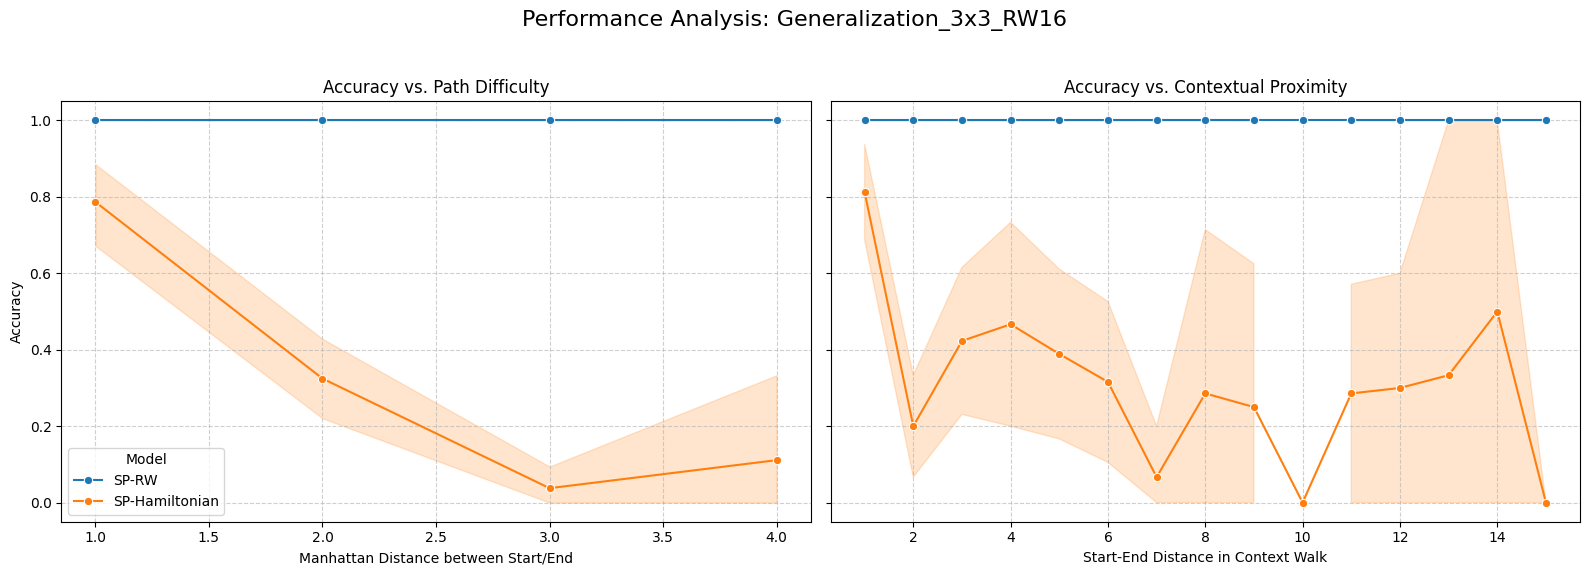

In [6]:
analysis_name = "Generalization_3x3_RW16"
params = ADVANCED_ANALYSIS_PARAMS[analysis_name]

shared_test_cases = create_test_cases(params)

if not shared_test_cases:
    logging.warning(f"Skipping analysis '{analysis_name}' as no test cases could be generated.")
else:
    for model_name, config in MODELS_TO_ANALYZE.items():
        results_df = run_advanced_analysis(config, shared_test_cases, model_name)
        logger.add(model_name, analysis_name, results_df)

    combined_df_for_plotting = logger.get_detailed_df(analysis_name=analysis_name)
    
    if not combined_df_for_plotting.empty:
        plot_stratified_results(combined_df_for_plotting, analysis_name)


Evaluating SP-RW: 100%|██████████| 200/200 [00:06<00:00, 31.99it/s]
2025-09-22 17:48:40,509 - INFO - Logged: Model=SP-RW, Analysis=Generalization_5x5_RW16, Accuracy=81.50%
Evaluating SP-Hamiltonian: 100%|██████████| 200/200 [00:05<00:00, 33.90it/s]
2025-09-22 17:48:46,578 - INFO - Logged: Model=SP-Hamiltonian, Analysis=Generalization_5x5_RW16, Accuracy=25.50%


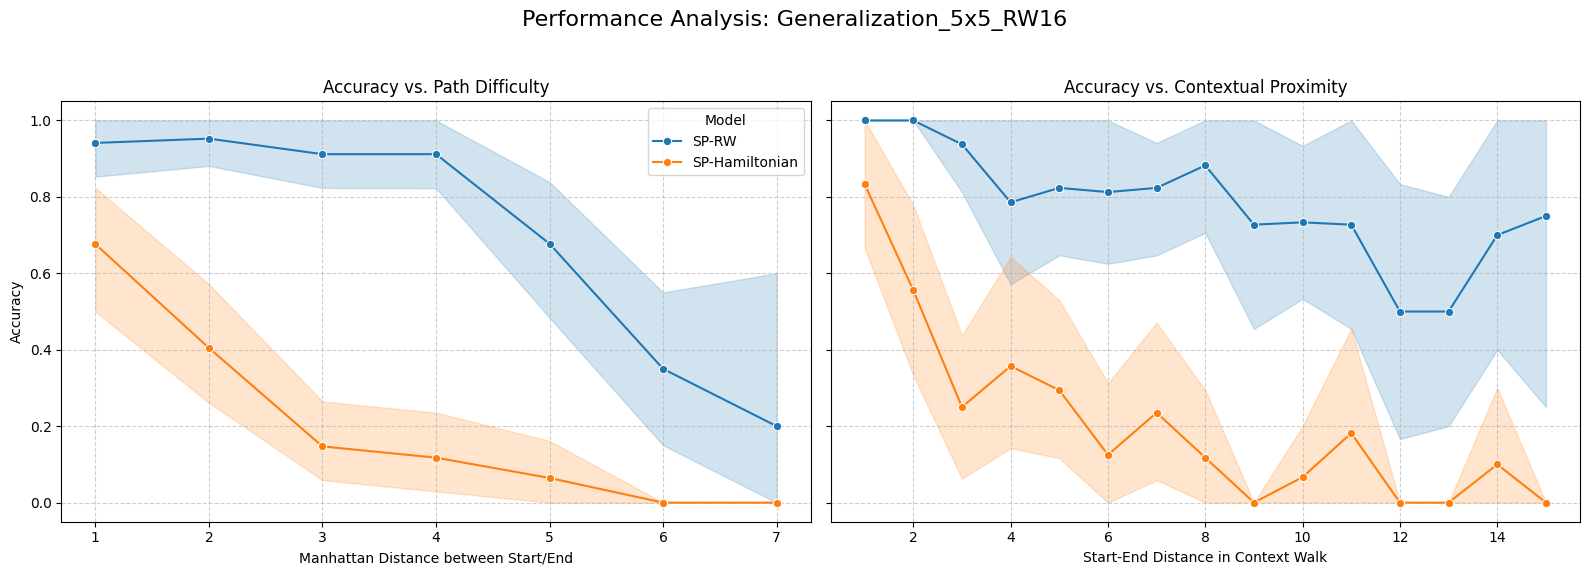

In [7]:
analysis_name = "Generalization_5x5_RW16"
params = ADVANCED_ANALYSIS_PARAMS[analysis_name]

shared_test_cases = create_test_cases(params)

if not shared_test_cases:
    logging.warning(f"Skipping analysis '{analysis_name}' as no test cases could be generated.")
else:
    for model_name, config in MODELS_TO_ANALYZE.items():
        results_df = run_advanced_analysis(config, shared_test_cases, model_name)
        logger.add(model_name, analysis_name, results_df)

    combined_df_for_plotting = logger.get_detailed_df(analysis_name=analysis_name)
    
    if not combined_df_for_plotting.empty:
        plot_stratified_results(combined_df_for_plotting, analysis_name)


In [8]:
summary_df = logger.get_summary_df()

if summary_df.empty:
    pass
else:
    styled_table = summary_df.style.format("{:.2%}", na_rep="-").background_gradient(
        cmap='viridis', vmin=0, vmax=1
    ).set_caption("Model Performance Summary")
    
    from IPython.display import display
    display(styled_table)
    
    logger.save_summary("final_model_performance_summary")
    logger.save_detailed_results("final_model_detailed_results")


Analysis,Baseline_4x4_Hamiltonian,RW_Context_Len_10,RW_Context_Len_16,RW_Context_Len_50,RW_Context_Len_55
Model,,,,,
SP-Hamiltonian,100.00%,0.00%,39.00%,0.00%,0.00%
SP-RW,94.00%,98.50%,99.50%,97.00%,17.50%
